In [2]:
from collections import Counter

import torch
import matplotlib.pyplot as plt

from torch import nn
from torchvision.datasets import DatasetFolder
from torchaudio import load, pipelines, transforms
from torch.utils.data import random_split

/Users/wsrtk/miniforge3/envs/torch3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# set manual seed for reproducibility
torch.manual_seed(0)
# load data and check
df = DatasetFolder('../data', 
    loader=lambda filepath: load(filepath)[0], 
    extensions=('wav'), 
    transform=transforms.Resample(44500, 16000)
    )
print(dict(Counter(df.targets)))
print(len(df))
# split data into train and test
train, test = random_split(df, (.8, .2))
print(len(train), len(test))

{0: 85, 1: 82, 2: 86, 3: 82, 4: 85}
420
336 84


In [36]:
# creatae pipeline
# bundle = pipelines.WAV2VEC2_BASE
bundle = pipelines.WAV2VEC2_ASR_BASE_10M
# WAV2VEC2_ASR_BASE_10M
bundle.sample_rate

16000

In [8]:
df[0]

(tensor([[0.3081, 0.7292, 0.6592,  ..., 0.6679, 0.7068, 0.5817]]), 0)

In [9]:
model = bundle.get_model()
# with torch.inference_mode():
#     features, _ = model.extract_features(df[0][0])
print(model)

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (2): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (3): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (4): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
      (6): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjec

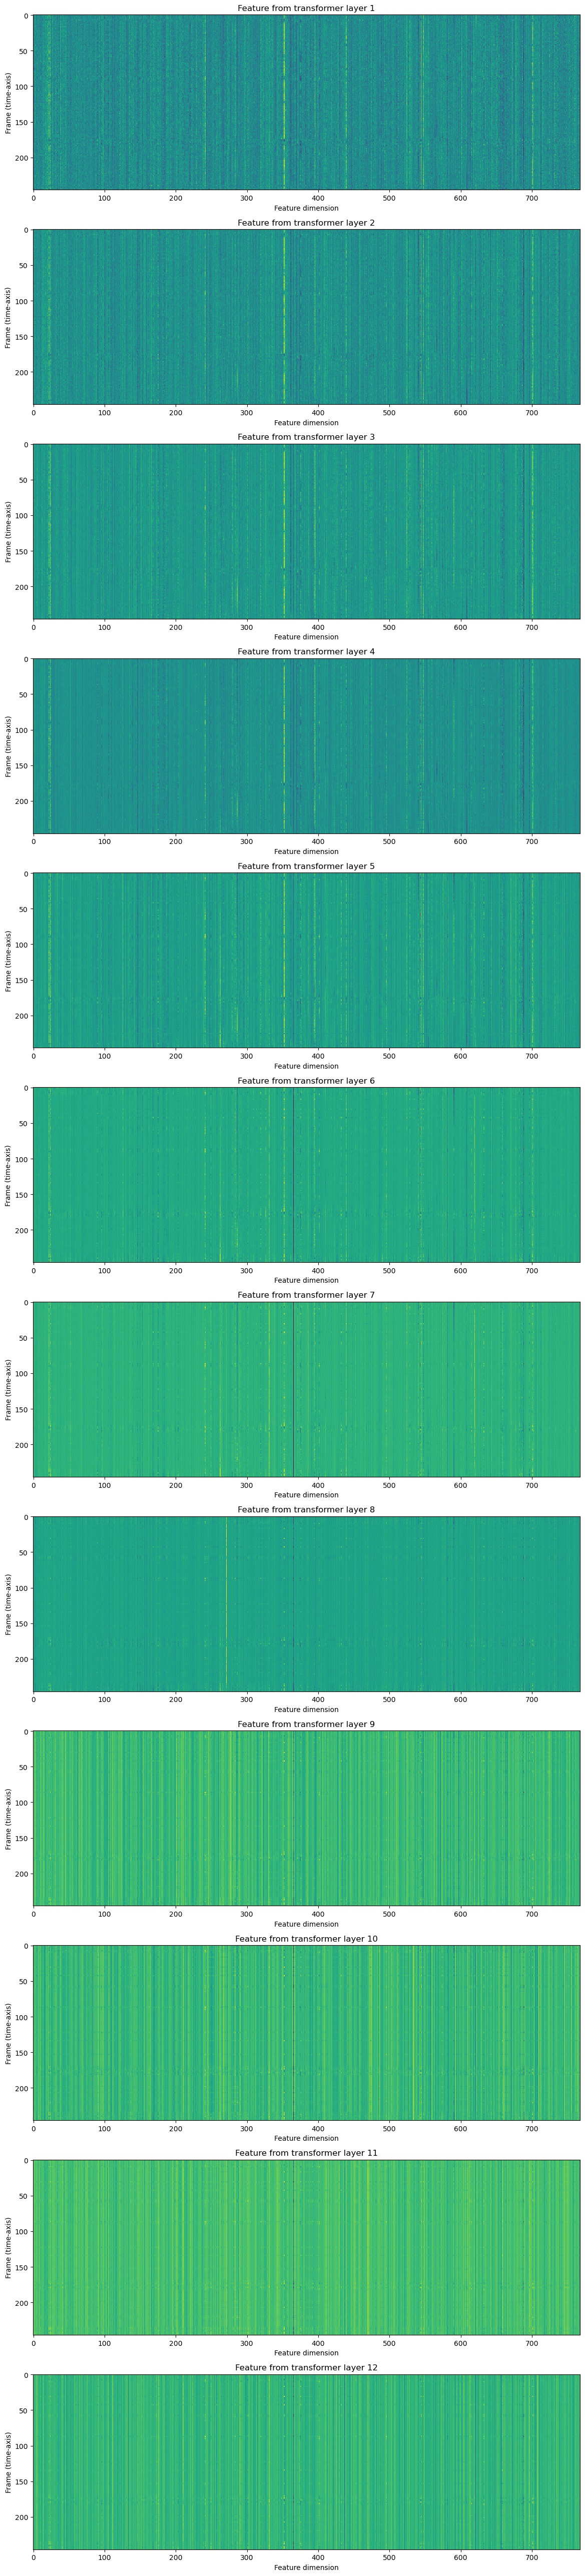

In [18]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [40]:
class NeedleNet(nn.Module):
    def __init__(self, bundle, num_labels=5):
        super(NeedleNet, self).__init__()
        self.num_labels = num_labels

        self.model = bundle.get_model()
        self.dropout = nn.Dropout(.1)
        self.classifier = nn.Linear(768, num_labels)

    def forward(self, x):
        outputs = self.model(x)
        # outputs = torch.sum(outputs, axis=1)
        outputs = self.dropout(outputs)
        outputs = self.classifier(outputs)
        return outputs

class Average(nn.Module):
    def __init__(self, axis):
        super().__init__()
        self.axis = axis

    def forward(self, x):
        output = x.mean(dim=self.axis)
        output = torch.squeeze(output, -2)
        return output

In [38]:
model = bundle.get_model()

In [43]:
model.aux = nn.Sequential(Average(axis=-2), nn.Linear(768, 5))
with torch.inference_mode():
    emission, _ = model(df[0][0])
print(emission.shape, emission)

torch.Size([5]) tensor([-0.2318,  0.2614, -0.0074,  0.1364,  0.0832])


In [32]:
m = nn.AdaptiveAvgPool1d(1)
m(emission.transpose(-2, -1)).shape, m(emission).shape

(torch.Size([1, 768, 1]), torch.Size([1, 246, 1]))

TypeError: Invalid shape () for image data

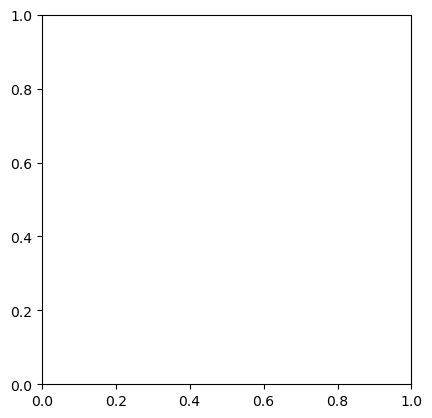

In [42]:
# plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [30]:
model

Wav2Vec2Model(
  (feature_extractor): FeatureExtractor(
    (conv_layers): ModuleList(
      (0): ConvLayerBlock(
        (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
      )
      (1): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (2): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (3): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (4): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
      )
      (5): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
      (6): ConvLayerBlock(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
      )
    )
  )
  (encoder): Encoder(
    (feature_projection): FeatureProjec